In [43]:
#PYTHONHASHSEED = 123

In [44]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import reciprocal
from sklearn.linear_model import Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
import xgboost as xgb

In [45]:
seed = 70308

In [46]:
np.random.seed(seed)

In [47]:
data_train = pd.read_csv("./train_val_test/train.csv", index_col = 'Unnamed: 0')

In [48]:
data_train

,Laptop_name,OS,CPU,CPU_Threads,CPU_Boosted_Clock,CPU_L3(MB),CPU_TDP(W),GPU,GPU_Memory(GB),GPU_Memory_Type,GPU memory clock(MHz),RAM(GB),RAM_DDR,Storage(GB),Display_Inch,Display_Height(pixel),Weight(kg),Brand,Price(USD)
637,Lenovo Yoga Slim 7 ProX 14ARH7-82TL000BGE,Windows,ryzen 9,16,4.9,16,35,geforce rtx 3050 mobile,4,GDDR6,1500,32,5,1024,14.5,3072,1.450,Lenovo,1945.0
1657,Gigabyte Aero 15 OLED XC,Windows,core i7,16,5.0,16,45,geforce rtx 3070 mobile,8,GDDR6,1750,32,4,1024,15.6,3840,2.230,Gigabyte Aero,2720.0
1376,Asus TUF Gaming A15 FA506QR-AZ061T,Windows,ryzen 7,16,4.4,16,45,geforce rtx 3070 mobile,8,GDDR6,1750,16,4,1024,15.6,1920,2.300,Asus,2011.0
733,LG Gram 14Z90Q,Windows,core i5,16,4.4,12,28,iris xe graphics g7 80eus,0,NaN,0,16,4,512,14.0,1920,0.980,LG,1156.0
608,Lenovo IdeaPad Flex 5i 14IAU7,Windows,core i5,12,4.4,12,15,iris xe graphics g7 80eus,0,NaN,0,16,4,512,14.0,1920,1.613,Lenovo,700.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
202,Asus Vivobook Pro 16X M7600QC-L2002T,Windows,ryzen 7,16,4.4,16,45,geforce rtx 3050 mobile,4,GDDR6,1500,16,4,1024,16.0,3840,1.950,Asus,1261.0
1724,"HP EliteBook x360 1040 G7, i7-10810U",Windows,core i7,12,4.9,12,25,uhd graphics 620,0,NaN,0,16,4,512,14.0,1920,1.361,HP,2500.0
1077,LG Gram 16 2-in-1 16T90P,Windows,core i7,8,4.7,12,28,iris xe graphics g7 96eus,0,NaN,0,16,4,512,16.0,2560,1.454,LG,1600.0
33,Acer Swift X SFX14-51G-79RJ,Windows,core i7,16,4.7,18,28,geforce rtx 3050 ti mobile,4,GDDR6,1500,16,5,1024,14.0,2240,1.400,Acer,1366.0


In [49]:
data_train.drop(axis = 1, labels = ['Brand', 'CPU', 'GPU', 'Laptop_name'], inplace = True)

In [50]:
y_train = np.log(data_train['Price(USD)'])
X_train = data_train.drop(axis = 1, labels = 'Price(USD)')

## Data Preparation

In [51]:
cat_attribs = ['GPU_Memory_Type', 'OS', 'RAM_DDR']
num_attribs = list(set(X_train.columns).difference(set(cat_attribs)))

In [52]:
X_train_original = X_train.copy()

### one-hot categorical attributes

In [53]:
oh_encoder = OneHotEncoder()
X_train_cat = oh_encoder.fit_transform(X_train[cat_attribs])
X_train = np.c_[X_train.drop(labels = cat_attribs, axis = 1).values,X_train_cat.toarray()]

In [54]:
oh_encoder.categories_

[array(['GDDR5', 'GDDR6', 'LPDDR4X', nan], dtype=object),
 array(['Linux', 'MacOS', 'Windows'], dtype=object),
 array([1, 3, 4, 5], dtype=int64)]

In [55]:
X_train = pd.DataFrame(X_train, index = data_train.index, 
                          columns = num_attribs + ['GDDR5','GDDR6','LPDDR4X','NoGPU'] + ['Linux', 'MacOS', 'Windows'] + ['DDR1','DDR3','DDR4','DDR5'])

### standardize numerical attributes

In [56]:
std_scaler = StandardScaler()
X_train[num_attribs] = std_scaler.fit_transform(X_train[num_attribs])

## Transformation pipelines

In [57]:
num_pipeline = Pipeline([
    ('std_scaler', StandardScaler())
])

full_pipeline = ColumnTransformer([
    ('num', num_pipeline, num_attribs),
    ('cat', OneHotEncoder(), cat_attribs)
])
full_pipeline.fit(X_train_original)

ColumnTransformer(transformers=[('num',
                                 Pipeline(steps=[('std_scaler',
                                                  StandardScaler())]),
                                 ['Display_Inch', 'GPU_Memory(GB)',
                                  'Display_Height(pixel)', 'CPU_TDP(W)',
                                  'RAM(GB)', 'CPU_L3(MB)', 'Storage(GB)',
                                  'CPU_Boosted_Clock', 'GPU memory clock(MHz)',
                                  'CPU_Threads', 'Weight(kg)']),
                                ('cat', OneHotEncoder(),
                                 ['GPU_Memory_Type', 'OS', 'RAM_DDR'])])

In [58]:
data_val = pd.read_csv("./train_val_test/test.csv", index_col = 'Unnamed: 0')
data_val.drop(['Year', 'CPU_Default_Clock', 'CPU_Transistor_Size(nm)', 'GPU clock(MHz)',
           'RAM_bus', 'CPU_Cores', 'GPU_Bus_Width(bit)', 'Display_Width(pixel)', 'Brand', 'CPU', 'GPU', 'Laptop_name'],
           axis = 1, inplace = True)
y_val = data_val['Price(USD)']
X_val = data_val.drop('Price(USD)', axis = 1)
X_val_prepared = full_pipeline.transform(X_val)
X_val_prepared = pd.DataFrame(X_val_prepared, index = y_val.index, columns = num_attribs + ['GDDR5','GDDR6','LPDDR4X','NoGPU'] + ['Linux', 'MacOS', 'Windows'] + ['DDR1','DDR3','DDR4','DDR5'])

## Ridge Regression

In [59]:
n = 50
best_alpha = None
best_error = float('inf')
best_estimator = None
rv = reciprocal(0.001, 10)
for alpha in rv.rvs(size = n):
    estimator = Ridge(alpha = alpha)
    estimator.fit(X_train, y_train)
    error = np.sqrt(mean_squared_error(y_val, np.exp(estimator.predict(X_val_prepared))))
    if error < best_error:
        best_estimator = estimator
        best_error = error
        best_alpha = alpha

In [60]:
print("best parameter: ",best_alpha)
print("rmse: ", best_error)

best parameter:  6.180376742169328
rmse:  1041.8387559670216


In [61]:
ridge = Ridge(alpha = best_alpha)
ridge.fit(pd.concat([X_train, X_val_prepared]), pd.concat([y_train, np.log(y_val)]))

Ridge(alpha=6.180376742169328)

<AxesSubplot:>

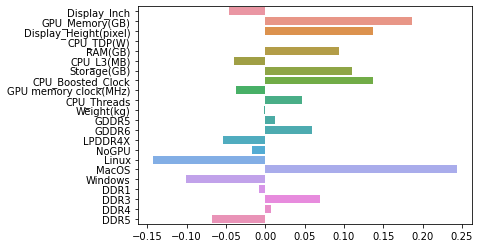

In [62]:
sns.barplot(y = X_train.columns, x = ridge.coef_, orient = 'h')

## Lasso Regression

In [63]:
n = 50
best_alpha = None
best_error = float('inf')
best_estimator = None
rv = reciprocal(0.001, 10)
for alpha in rv.rvs(size = n):
    estimator = Lasso(alpha = alpha)
    estimator.fit(X_train, y_train)
    error = np.sqrt(mean_squared_error(y_val, np.exp(estimator.predict(X_val_prepared))))
    if error < best_error:
        best_estimator = estimator
        best_error = error
        best_alpha = alpha

In [64]:
print("best parameter: ",best_alpha)
print("rmse: ", best_error)

best parameter:  0.085849710908814
rmse:  736.021732607631


In [65]:
lasso = Lasso(alpha = best_alpha)
lasso.fit(pd.concat([X_train, X_val_prepared]), pd.concat([y_train, np.log(y_val)]))

Lasso(alpha=0.085849710908814)

<AxesSubplot:>

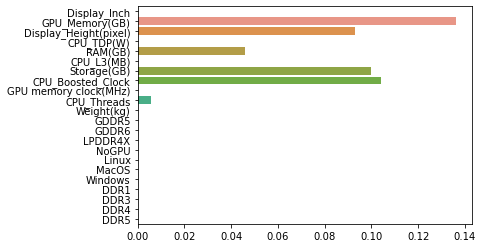

In [66]:
sns.barplot(y = X_train.columns, x = lasso.coef_, orient = 'h')

## Random Forest

In [67]:
max_n_estimators = 100
best_n_estimators = None
best_error = float('inf')
best_estimator = None
errors = []
for n_estimators in range(1, max_n_estimators):
    estimator = RandomForestRegressor(n_estimators = n_estimators)
    estimator.fit(X_train, y_train)
    error = np.sqrt(mean_squared_error(y_val, np.exp(estimator.predict(X_val_prepared))))
    errors.append(error)
    if error < best_error:
        best_estimator = estimator
        best_error = error
        best_n_estimators = n_estimators

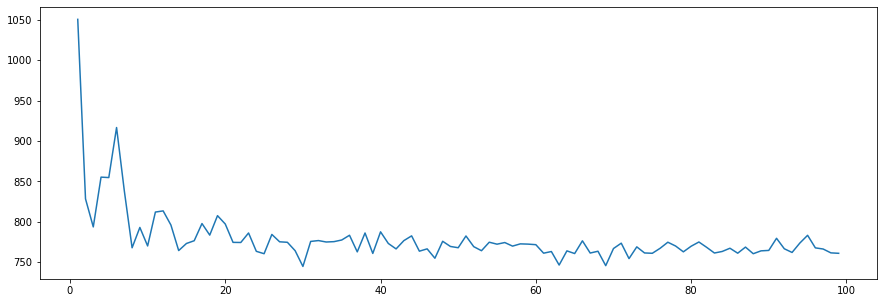

In [68]:
plt.figure(figsize = (15, 5))
plt.plot(range(1, max_n_estimators), errors)

In [69]:
print("best parameter: ",best_n_estimators)
print("rmse: ", best_error)

best parameter:  30
rmse:  744.5791498384048


In [70]:
forest_reg = RandomForestRegressor(n_estimators = best_n_estimators)
forest_reg.fit(pd.concat([X_train, X_val_prepared]), pd.concat([y_train, np.log(y_val)]))

RandomForestRegressor(n_estimators=30)

Text(0.5, 0, '%')

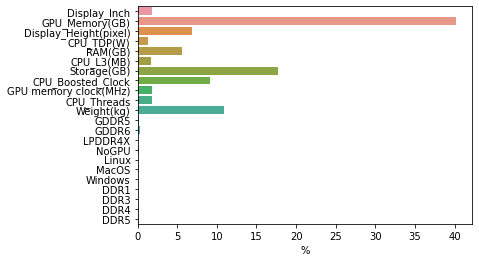

In [71]:
sns.barplot(y = X_train.columns, x = forest_reg.feature_importances_ * 100, orient = 'h')
plt.xlabel('%')

## Extreme Gradient Boosting

In [72]:
max_n_estimators = 100
best_n_estimators = None
best_error = float('inf')
best_estimator = None
errors = []
for n_estimators in range(1, max_n_estimators):
    estimator = xgb.XGBRegressor(n_estimators = n_estimators)
    estimator.fit(X_train, y_train)
    error = np.sqrt(mean_squared_error(y_val, np.exp(estimator.predict(X_val_prepared))))
    errors.append(error)
    if error < best_error:
        best_estimator = estimator
        best_error = error
        best_n_estimators = n_estimators

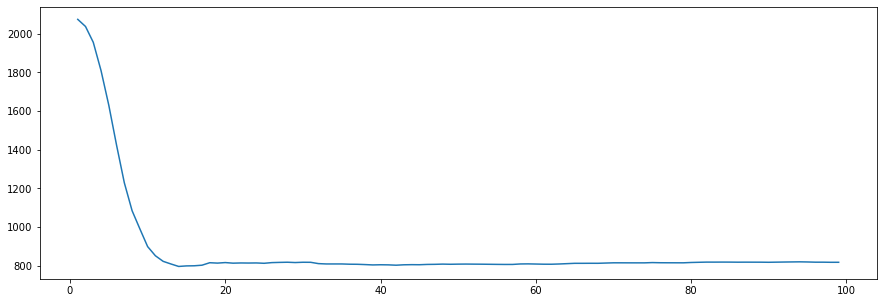

In [73]:
plt.figure(figsize = (15, 5))
plt.plot(range(1, max_n_estimators), errors) 

In [74]:
print("best parameter: ",best_n_estimators)
print("rmse: ", best_error)

best parameter:  14
rmse:  796.4062080282321


In [75]:
xgb_reg = xgb.XGBRegressor(n_estimators = best_n_estimators)
xgb_reg.fit(pd.concat([X_train, X_val_prepared]), pd.concat([y_train, np.log(y_val)]))

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=14, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

Text(0.5, 0, '%')

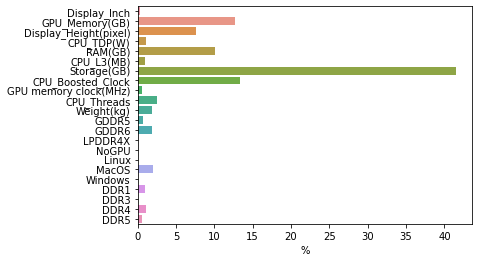

In [76]:
sns.barplot(y = X_train.columns, x = xgb_reg.feature_importances_ * 100, orient = 'h')
plt.xlabel('%')

## Final results

In [77]:
data_test = pd.read_csv("./train_val_test/test.csv", index_col = 'Unnamed: 0')

In [78]:
data_test.drop(['Year', 'CPU_Default_Clock', 'CPU_Transistor_Size(nm)', 'GPU clock(MHz)',
           'RAM_bus', 'CPU_Cores', 'GPU_Bus_Width(bit)', 'Display_Width(pixel)', 'Brand', 'CPU', 'GPU', 'Laptop_name'],
           axis = 1, inplace = True)
y_test = data_test['Price(USD)']
X_test = data_test.drop('Price(USD)', axis = 1)

In [79]:
X_test_prepared = full_pipeline.transform(X_test)
X_test_prepared = pd.DataFrame(X_test_prepared, index = y_test.index, columns = num_attribs + ['GDDR5','GDDR6','LPDDR4X','NoGPU'] + ['Linux', 'MacOS', 'Windows'] + ['DDR1','DDR3','DDR4','DDR5'])

In [80]:
np.sqrt(mean_squared_error(np.exp(ridge.predict(X_test_prepared)), y_test))

803.4303659324271

In [81]:
np.sqrt(mean_squared_error(np.exp(lasso.predict(X_test_prepared)), y_test))

697.6279365194126

In [82]:
np.sqrt(mean_squared_error(np.exp(forest_reg.predict(X_test_prepared)), y_test))

268.53319152105996

In [83]:
np.sqrt(mean_squared_error(np.exp(xgb_reg.predict(X_test_prepared)), y_test))

479.5963430530757

In [84]:
#268.53319152105996